# Library import

In [175]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from counterplots import CreatePlot

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbalanced_make_pipeline

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, classification_report, silhouette_score, roc_auc_score, recall_score, precision_score, fbeta_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.core.metrics import make_scorer as ag_make_scorer

from scipy.spatial.distance import cdist
import dice_ml

from collections import Counter
import copy
import time
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Data load

In [176]:
df = pd.read_csv("Data/oulad_data.csv", delimiter=',')
df.set_index("id_student", inplace=True)

df.drop(columns=["code_module", "code_presentation", "gender", "region", "highest_education", "imd_band", "age_band", "num_of_prev_attempts", "studied_credits", "disability", "TMA1", "TMA2", "TMA3", "TMA4", "TMA5", "TMA6"], inplace=True)

In [177]:
df

,final_result,week_-4,week_-3,week_-2,week_-1,week_0,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_minus_4_homepage,week_minus_4_resource,week_minus_4_subpage,week_minus_4_oucontent,week_minus_4_url,week_minus_4_glossary,week_minus_3_homepage,week_minus_3_oucontent,week_minus_3_resource,week_minus_3_subpage,week_minus_3_url,week_minus_3_externalquiz,week_minus_3_glossary,week_minus_3_forumng,week_minus_3_oucollaborate,week_minus_3_ouwiki,week_minus_2_forumng,week_minus_2_homepage,week_minus_2_subpage,week_minus_2_url,week_minus_2_externalquiz,week_minus_2_oucontent,week_minus_2_oucollaborate,week_minus_2_resource,week_minus_2_ouwiki,week_minus_2_glossary,week_minus_1_forumng,week_minus_1_homepage,week_minus_1_oucollaborate,week_minus_1_oucontent,week_minus_1_subpage,week_minus_1_url,week_minus_1_resource,week_minus_1_externalquiz,week_minus_1_ouwiki,week_minus_1_glossary,week_0_externalquiz,week_0_forumng,week_0_homepage,week_0_oucollaborate,week_0_oucontent,week_0_ouwiki,week_0_resource,week_0_subpage,week_0_url,week_0_glossary,week_1_forumng,week_1_homepage,week_1_oucollaborate,week_1_oucontent,week_1_resource,week_1_subpage,week_1_url,week_1_externalquiz,week_1_ouwiki,week_1_glossary,week_2_homepage,week_2_oucontent,week_2_url,week_2_forumng,week_2_resource,week_2_subpage,week_2_externalquiz,week_2_ouwiki,week_2_oucollaborate,week_2_glossary,week_3_externalquiz,week_3_homepage,week_3_oucontent,week_3_resource,week_3_subpage,week_3_url,week_3_forumng,week_3_ouwiki,week_3_glossary,week_3_oucollaborate,week_4_externalquiz,week_4_homepage,week_4_oucontent,week_4_resource,week_4_subpage,week_4_url,week_4_forumng,week_4_ouwiki,week_4_glossary,week_4_oucollaborate,week_5_homepage,week_5_oucollaborate,week_5_oucontent,week_5_resource,week_5_subpage,week_5_url,week_5_forumng,week_5_ouwiki,week_5_externalquiz,week_5_glossary,week_6_forumng,week_6_homepage,week_6_oucollaborate,week_6_oucontent,week_6_ouwiki,week_6_subpage,week_6_resource,week_6_url,week_6_externalquiz,week_6_glossary,week_7_homepage,week_7_oucontent,week_7_resource,week_7_subpage,week_7_forumng,week_7_oucollaborate,week_7_url,week_7_ouwiki,week_7_externalquiz,week_7_glossary,week_8_homepage,week_8_subpage,week_8_forumng,week_8_oucontent,week_8_ouwiki,week_8_resource,week_8_url,week_8_externalquiz,week_8_glossary,week_8_oucollaborate,week_9_homepage,week_9_forumng,week_9_oucontent,week_9_url,week_9_externalquiz,week_9_subpage,week_9_resource,week_9_oucollaborate,week_9_glossary,week_9_ouwiki,week_10_externalquiz,week_10_homepage,week_10_oucontent,week_10_resource,week_10_subpage,week_10_url,week_10_forumng,week_10_oucollaborate,week_10_glossary,week_10_ouwiki,week_11_homepage,week_11_resource,week_11_subpage,week_11_forumng,week_11_oucontent,week_11_url,week_11_externalquiz,week_11_oucollaborate,week_11_ouwiki,week_11_glossary,week_12_externalquiz,week_12_homepage,week_12_oucontent,week_12_resource,week_12_subpage,week_12_url,week_12_forumng,week_12_oucollaborate,week_12_glossary,week_12_ouwiki,week_13_forumng,week_13_homepage,week_13_resource,week_13_subpage,week_13_url,week_13_oucontent,week_13_externalquiz,week_13_oucollaborate,week_13_ouwiki,week_13_glossary,week_14_homepage,week_14_oucontent,week_14_resource,week_14_forumng,week_14_subpage,week_14_url,week_14_externalquiz,week_14_oucollaborate,week_14_ouwiki,week_14_glossary,week_15_homepage,week_15_resource,week_15_subpage,week_15_forumng,week_15_oucontent,week_15_url,week_15_ouwiki,week_15_oucollaborate,week_15_externalquiz,week_15_glossary,week_16_homepage,week_16_subpage,week_16_url,week_16_forumng,week_16_oucollaborate,week_16_resource,week_16_oucontent,week_16_externalquiz,week_16_ouwiki,week_16_glossary,week_17_homepage,week_17_forumng,week_17_subpage,week_17_url,we

In [178]:
week_columns = [col for col in df.columns if col.startswith("week_")]
classes_columns = []

classes = set()
for col in week_columns:
    last_part = col.split("_")[-1]
    if last_part.isalpha():
        classes.add(last_part)

classes = sorted(classes)
classes.append("total_n_clicks")

def ends_with_number(col):
    last_part = col.split("_")[-1]
    return last_part.isdigit()

for cls in classes:
    if cls != "total_n_clicks": 
        matching_columns = [col for col in week_columns if cls in col]
        classes_columns+=matching_columns

        df[f'n_clicks_{cls}'] = df[matching_columns].sum(axis=1)

    else:        
        matching_columns = [col for col in week_columns if col not in classes_columns]
        
        df[cls] = df[matching_columns].sum(axis=1)

df = df.drop(columns=week_columns)

In [179]:
categorical_features = df.select_dtypes(include=['object', 'bool']).columns
categorical_features = categorical_features.drop("final_result")

numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

df["final_result"] = df["final_result"].apply(lambda x: "Pass" if x == "Distinction" else x)
df["final_result"] = df["final_result"].apply(lambda x: 0 if x == "Pass" else 1)
# 0 = Pass, 1 = Fail

cols = list(df.columns)
cols.remove("final_result")
cols.append("final_result")
df = df[cols]

In [180]:
df

,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks,final_result
id_student,,,,,,,,,,,,
27935,3,142,0,259,2,64,38,41,231,33,813,1
28046,10,92,0,162,0,100,75,32,175,15,661,1
29411,24,169,4,211,1,54,74,87,193,24,841,0
30549,2,7,0,58,2,32,0,3,33,0,137,1
31173,7,162,0,212,6,228,110,44,87,2,858,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2678380,14,202,0,225,23,72,0,93,247,24,900,0
2680988,12,655,5,464,9,243,0,105,328,51,1872,1
2684043,9,93,9,185,1,127,0,47,76,39,586,0


In [181]:
nan_values = {col: df[col].isna().sum() for col in df.columns if df[col].isna().sum() > 0}
nan_values

{}

In [182]:
df.duplicated().sum()

0

In [183]:
#detect and drop nan values
df.dropna(inplace=True)

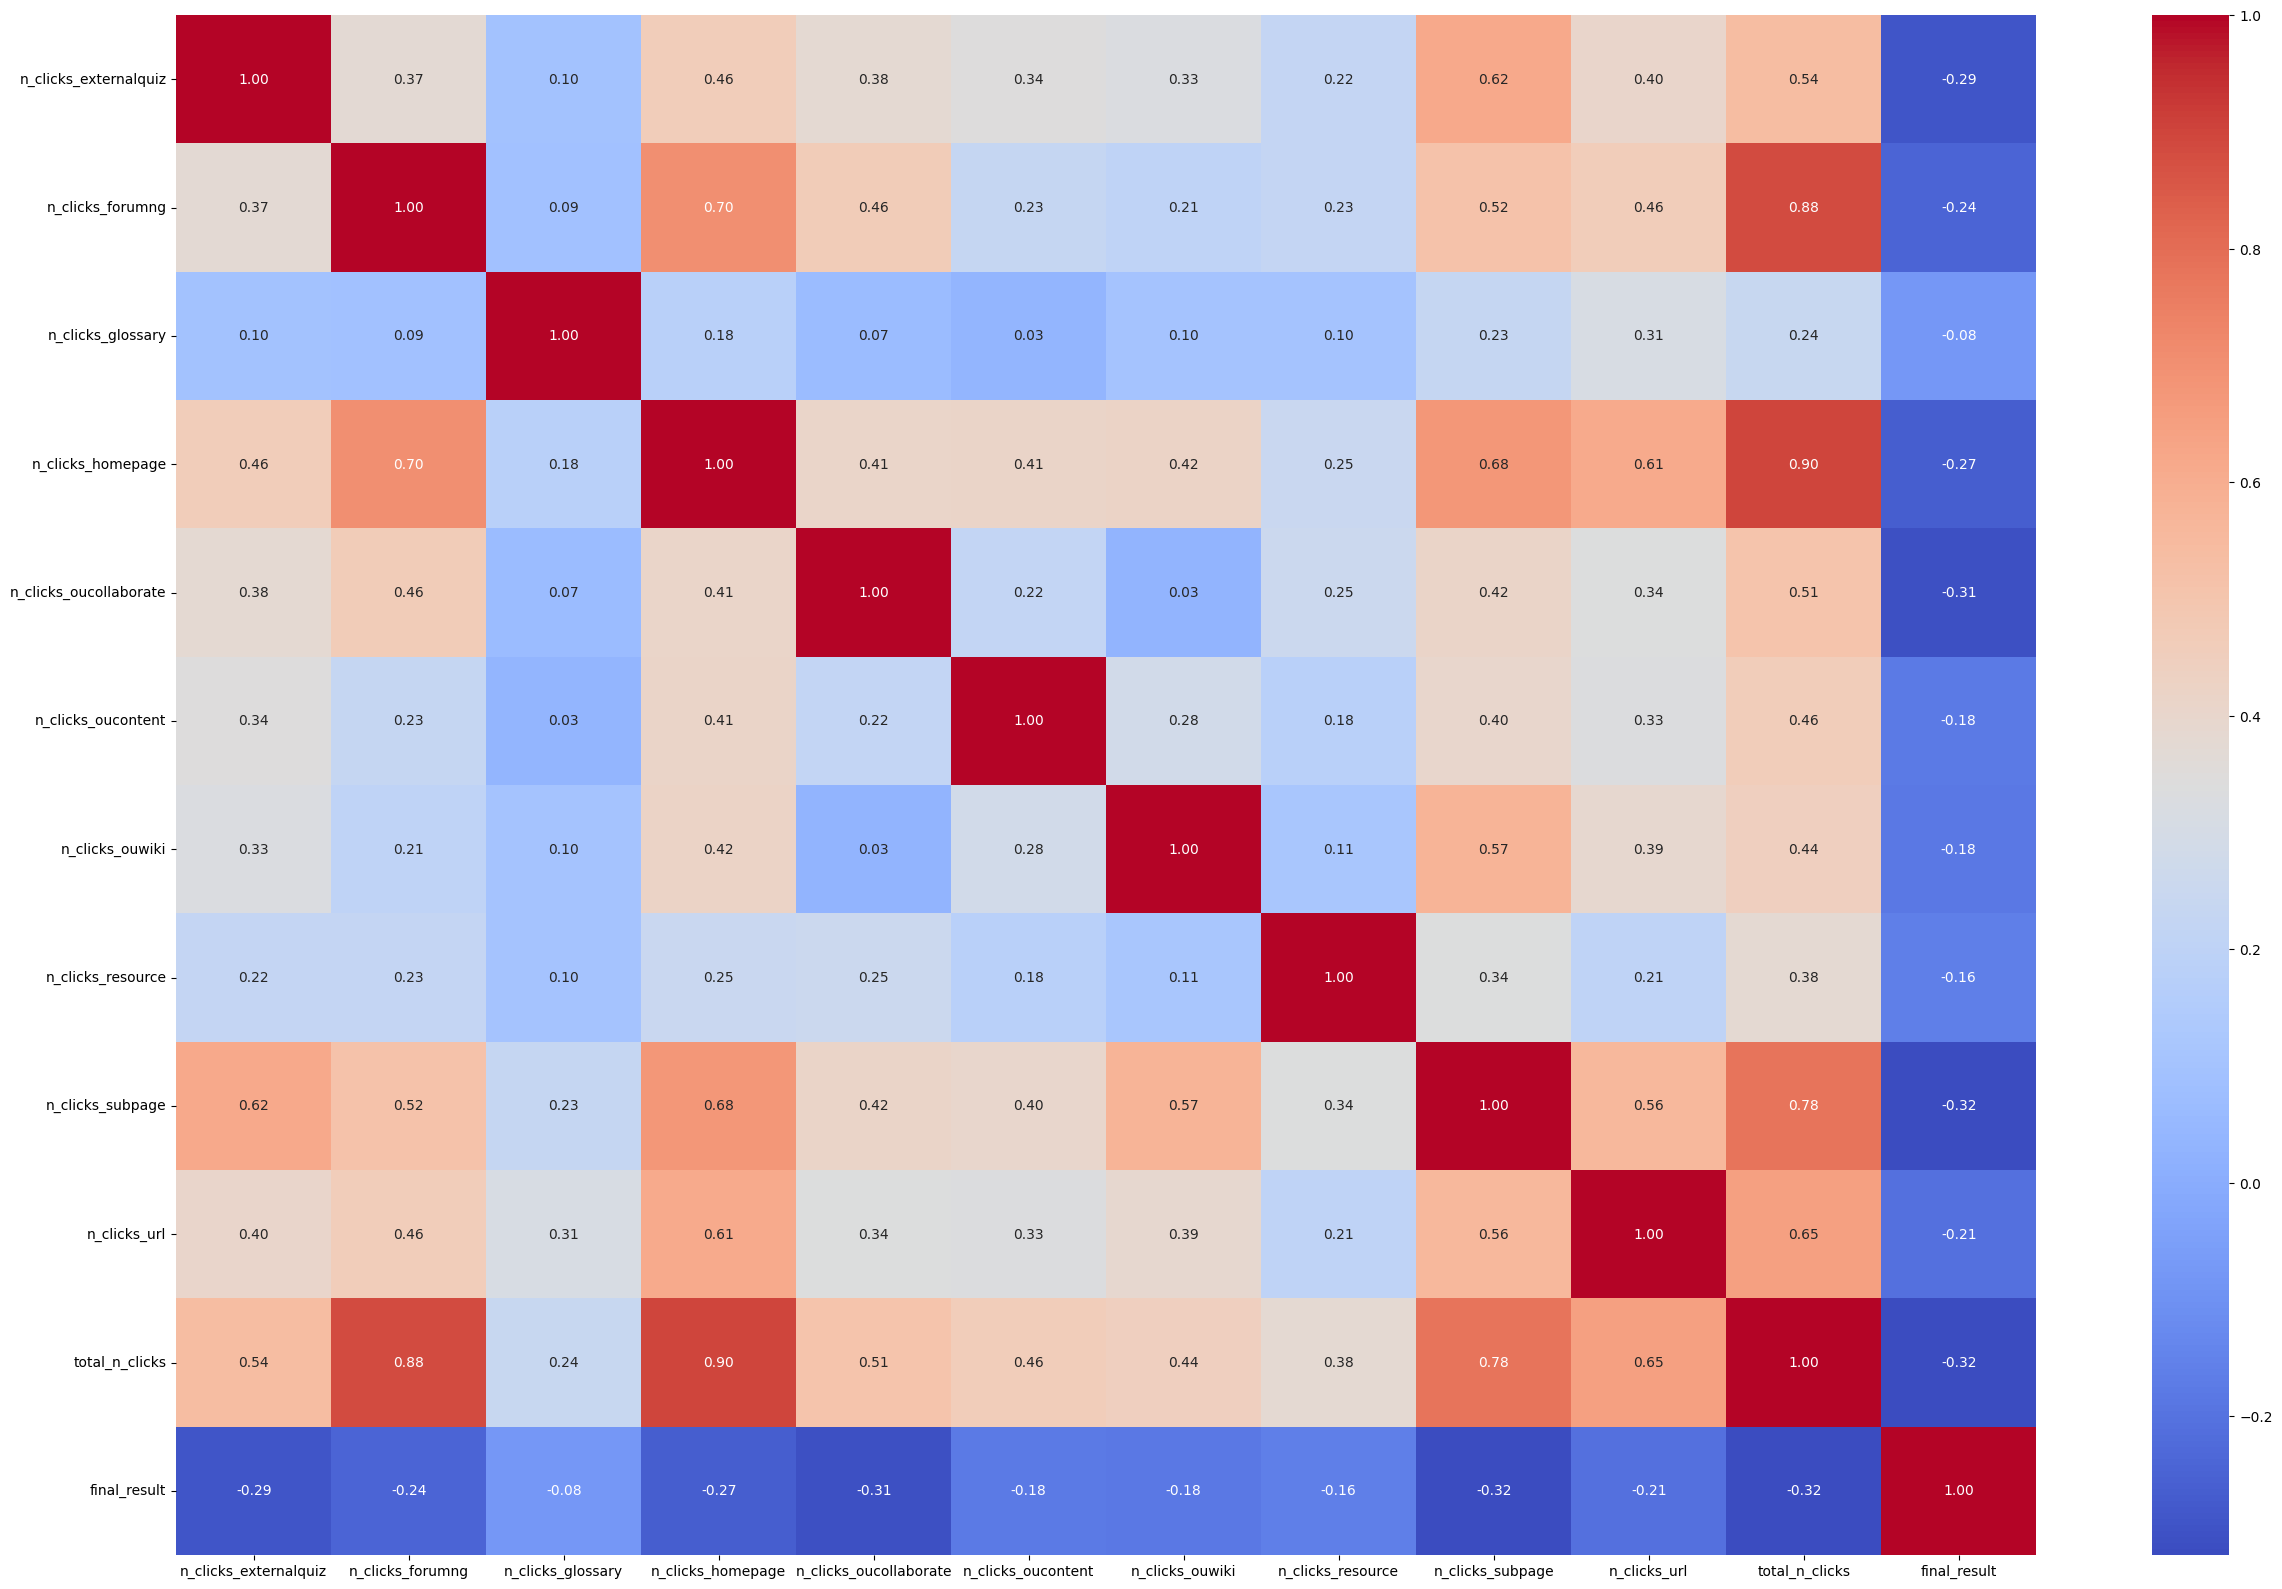

In [184]:
plt.figure(figsize=(30, 20))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [185]:
print(df["final_result"].value_counts())

0    1620
1     676
Name: final_result, dtype: int64


In [186]:
encoder = OrdinalEncoder()
df[categorical_features] = encoder.fit_transform(df[categorical_features])

# Split train/test

In [187]:
# In case u want to load the already preprocessed data, run this cell
df = pd.read_csv("Data/oulad_data_preprocessed.csv", delimiter=',')

In [188]:
X = df.drop('final_result', axis=1)
y = df['final_result']

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, df['final_result'], test_size=0.3, stratify=y, random_state=42)

In [190]:
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, zero_division=0)

## Random Forest

In [191]:
pipeline = imbalanced_make_pipeline(steps=[
    ('smote', SMOTE(random_state=42)), 
    ('classifier', RandomForestClassifier(n_estimators=1000, class_weight='balanced', random_state=42))
])

rf_model = pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
predictions_prob = pipeline.predict_proba(X_test)

predictions_train = pipeline.predict(X_train)
predictions_train_prob = pipeline.predict_proba(X_train)

In [192]:
rf_model

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=42))])

Accuracy: 0.7518142235123367
Precision: 0.5655737704918032
Recall: 0.6798029556650246
F1 Score: 0.6174496644295302
F2 Score: 0.6534090909090909
ROC AUC: 0.8141509051470737

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.78      0.82       486
           1       0.57      0.68      0.62       203

    accuracy                           0.75       689
   macro avg       0.71      0.73      0.72       689
weighted avg       0.77      0.75      0.76       689



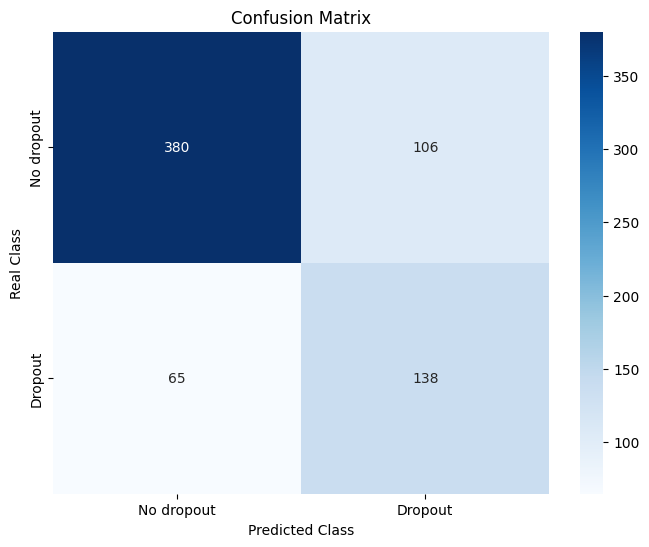

In [193]:
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("F2 Score:", f2_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No dropout', 'Dropout'], yticklabels=['No dropout', 'Dropout'])
plt.title("Confusion Matrix")
plt.ylabel("Real Class")
plt.xlabel("Predicted Class")
plt.show()

## Autogluon

In [ ]:
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

train_data = TabularDataset(X_train.join(y_train))
test_data = TabularDataset(X_test.join(y_test))

predictor = TabularPredictor(label="final_result", eval_metric=ag_make_scorer(name='f2', score_func=f2_score))
autogluon_model = predictor.fit(train_data, presets='best_quality', time_limit=3600, verbosity=0)

In [ ]:
autogluon_model

Accuracy: 0.7460087082728593
Precision: 0.5542635658914729
Recall: 0.7044334975369458
F1 Score: 0.6203904555314533
F2 Score: 0.6682242990654206
ROC AUC: 0.8041618520545724

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       486
           1       0.55      0.70      0.62       203

    accuracy                           0.75       689
   macro avg       0.71      0.73      0.71       689
weighted avg       0.77      0.75      0.75       689



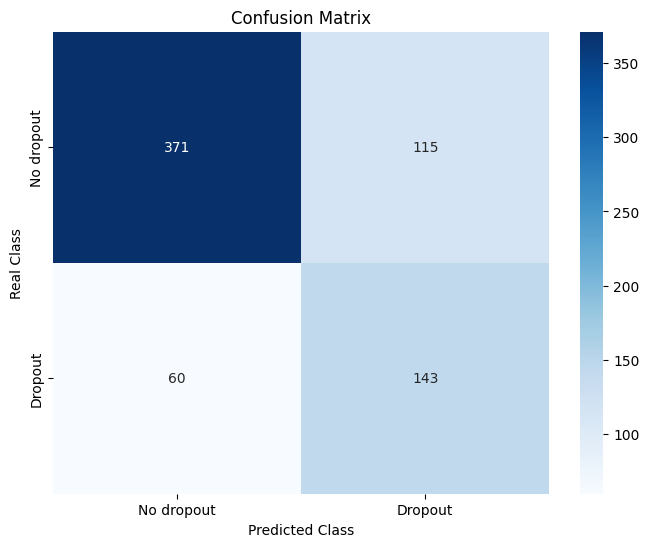

2024-12-28 21:47:02,387	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-12-28 21:47:02,389	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-12-28 21:47:02,390	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-12-28 21:47:02,391	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-12-28 21:47:02,392	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UN

In [ ]:
y_pred = predictor.predict(test_data.drop(columns=["final_result"]))
y_proba = predictor.predict_proba(test_data.drop(columns=["final_result"]))[1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("F2 Score:", f2_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No dropout', 'Dropout'], yticklabels=['No dropout', 'Dropout'])
plt.title("Confusion Matrix")
plt.ylabel("Real Class")
plt.xlabel("Predicted Class")
plt.show()

In [219]:
model = rf_model

In [220]:
model

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=42))])

In [221]:
features_to_not_vary = ["code_module", "code_presentation", "gender", "region", "imd_band", "age_band", "disability","final_result"]
features_to_vary = [col for col in df.columns if col not in features_to_not_vary]

In [222]:
#Create DiCE explainer for generating individual counterfactuals

d = dice_ml.Data(dataframe=df,
                 continuous_features=numerical_features.tolist(),
                 outcome_name='final_result')

m = dice_ml.Model(model=model, backend="sklearn")

exp = dice_ml.Dice(d,m)

In [223]:
queries = X_test[y_test == 1].sample(5, random_state=42)
counterfactuals = exp.generate_counterfactuals(queries, total_CFs=3, desired_class="opposite", features_to_vary=features_to_vary)
counterfactuals.visualize_as_dataframe(show_only_changes=True)

predictions_proba = model.predict_proba(queries)
    
print(predictions_proba)

100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

Query instance (original outcome : 1)


,id_student,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks,final_result
0,554746,2,44,0,150,4,186,0,43,34,5,468,1



Diverse Counterfactual set (new outcome: 0)


,id_student,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks,final_result
0,-,286,-,-,-,-,-,-,3916,-,-,-,0
1,-,-,-,-,-,227,-,422,-,-,-,-,0
2,-,-,-,-,-,-,-,452,3001,-,-,-,0


Query instance (original outcome : 0)


,id_student,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks,final_result
0,579470,0,56,0,131,2,281,43,41,95,14,663,0



Diverse Counterfactual set (new outcome: 1)


,id_student,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks,final_result
0,-,-,-,-,-,-,-,-,-,-,-,11957,1
1,-,-,-,939,-,-,1117,-,-,-,-,-,-
2,-,-,-,-,-,-,-,-,3459,-,-,7580,1


Query instance (original outcome : 1)


,id_student,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks,final_result
0,649383,14,121,63,213,1,74,0,37,77,16,616,1



Diverse Counterfactual set (new outcome: 0)


,id_student,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks,final_result
0,-,-,-,-,-,-,-,-,-,-,610,-,0
1,-,-,-,-,4256,-,-,-,-,-,-,7834,0
2,-,-,-,-,-,-,-,-,1197,-,-,-,0


Query instance (original outcome : 1)


,id_student,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks,final_result
0,652428,4,225,19,145,6,68,0,26,128,2,623,1



Diverse Counterfactual set (new outcome: 0)


,id_student,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks,final_result
0,-,-,-,-,-,-,-,-,1457,-,-,-,0
1,-,-,-,-,6875,175,-,-,-,-,-,-,0
2,-,78,-,-,-,-,-,-,-,-,-,-,0


Query instance (original outcome : 1)


,id_student,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks,final_result
0,563770,5,77,0,49,0,141,18,25,53,1,369,1



Diverse Counterfactual set (new outcome: 0)


,id_student,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks,final_result
0,-,-,4137,-,3844,-,-,-,-,-,-,-,0
1,-,-,-,-,-,51,-,-,-,2656,-,-,0
2,-,13,-,-,-,-,-,-,738,-,-,-,0


[[0.348 0.652]
 [0.532 0.468]
 [0.495 0.505]
 [0.408 0.592]
 [0.255 0.745]]


# Group counterfactual generator algorithm with KNN

In [21]:
negative_outcome = [y_train.iloc[instance] for instance in np.where(predictions == 1)][0] # students who dont pass in the test set
positive_outcome = [y_train.iloc[instance] for instance in np.where(predictions == 0)][0] # students who pass in the test set

positive_train_set = [X_train.iloc[instance] for instance in np.where(predictions == 0)][0] # students who pass in the train set
negative_train_set = positive = [X_train.iloc[instance] for instance in np.where(predictions == 1)][0] # students who dont pass in the train set

In [22]:
positive_train_indices = sorted(set(np.where(y_train==0)[0]).intersection(set(np.where(predictions_train == y_train)[0]))) # students who pass in the train set and are correctly classified
negative_train_set_indices = sorted(set(np.where(y_train==1)[0]).intersection(set(np.where(predictions_train == y_train)[0]))) # students who dont pass in the train set and are correctly classified

positive_train_set = X_train.iloc[positive_train_indices] # students who pass in the train set and are correctly classified
negative_train_set = X_train.iloc[negative_train_set_indices] # students who dont pass in the train set and are correctly classified

In [23]:
N_NEIGHBORS = 5

neighbors_negative = NearestNeighbors(n_neighbors=N_NEIGHBORS, metric='hamming').fit(negative_train_set) # fit the nearest neighbors model with the negative train set
neighbors_positive = NearestNeighbors(n_neighbors=N_NEIGHBORS, metric='hamming').fit(positive_train_set) # fit the nearest neighbors model with the positive train set

## Functions

In [24]:
# This function finds the nearest unlike neighbor (NUN) of a query instance

def NUN_finder(row, outcome, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set):
    if outcome not in ['negative', 'positive']:
        raise ValueError("Outcome must be 'negative' or 'positive'")
    
    row_reshaped = row.reshape(1, -1)
    
    # Find the nearest unlike neighbors of the query instance
    if outcome == 'negative':
        distances, indices = neighbors_positive.kneighbors(row_reshaped)
        NUN = positive_train_set.iloc[indices[0][0]]
        
    # Find the nearest unlike neighbors of the query instance
    elif outcome == 'positive':
        distances, indices = neighbors_negative.kneighbors(row_reshaped)
        NUN = negative_train_set.iloc[indices[0][0]]

    # Return the NUN       
    return NUN

In [25]:
# This function generates the explanation for a query instance

def explanation_generator(query, outcome, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, number_of_NNs=N_NEIGHBORS): 
    if outcome not in ['negative', 'positive']:
        raise ValueError("Outcome must be 'negative' or 'positive'")
    
    query_reshaped = query.reshape(1, -1)
    NUNs = []

    if outcome == 'negative':

        # Find the nearest neighbors of the query instance in the negative class
        distances_neg, indices_neg = neighbors_negative.kneighbors(query_reshaped)
        NNs = (negative_train_set.iloc[indices_neg[0][0:number_of_NNs]])

        # Find the nearest unlike neighbor (NUN) of the query instance in the positive class
        distances, indices_pos = neighbors_positive.kneighbors(query_reshaped)
        NUN = positive_train_set.iloc[indices_pos[0][0]]

        # Find the NUNs of the nearest neighbors of the query instance in the negative class
        rows = [np.array(row) for row in NNs.itertuples(index=False, name=None)]

        for row in rows:
            NUNs.append(NUN_finder(row, outcome, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set))

        # Return the query instance, the nearest neighbors, the NUN, the NUNs of the nearest neighbors, and the indices of the NUNs
        return query, NUN, NNs, NUNs, indices_neg
    
    elif outcome == 'positive':

        # Find the nearest neighbors of the query instance in the positive class
        distances_pos, indices_pos = neighbors_positive.kneighbors(query_reshaped)
        NNs = (positive_train_set.iloc[indices_pos[0][0:number_of_NNs]])

        # Find the nearest unlike neighbor (NUN) of the query instance in the negative class
        distances_neg, indices_neg = neighbors_negative.kneighbors(query_reshaped)
        NUN = negative_train_set.iloc[indices_neg[0][0]]
        
        # Find the NUNs of the nearest neighbors of the query instance in the positive class
        rows = [np.array(row) for row in NNs.itertuples(index=False, name=None)]

        for row in rows:
            NUNs.append(NUN_finder(row, outcome, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set))

        # Return the query instance, the nearest neighbors, the NUN, the NUNs of the nearest neighbors, and the indices of the NUNs
        return query, NUN, NNs, NUNs, indices_pos

In [26]:
# This function generates the explanations for a student and his/her nearest neighbors

def cfe_generator(student, X_test, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, model, explainer, features_to_vary, number_of_cfe=N_NEIGHBORS):

    explanations = [None] * number_of_cfe
    indexes = []
    indexes.append(student)

    # Predict the class of the query instance
    predicted_class = model.predict(X_test.loc[[student]]).round()

    # Generate counterfactual examples for the query instance
    if predicted_class == 0:
        outcome = "positive"
        # Find the nearest neighbors of the query instance in the negative class
        NNs = explanation_generator((np.array(X_test.loc[[student]])).reshape(1,-1), outcome, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set)[2]
        # Generate counterfactual examples for the query instance
        explanations[0] = explainer.generate_counterfactuals(X_test.loc[[student]], total_CFs=1, desired_class="opposite", features_to_vary=features_to_vary)

        # Generate counterfactual examples for the nearest neighbors of the query instance in the negative class
        for i in range(number_of_cfe-1):
           explanations[i+1] = explainer.generate_counterfactuals(NNs.iloc[[i]], total_CFs=1, desired_class="opposite", features_to_vary=features_to_vary)
           indexes.extend(NNs.iloc[[i]].index.tolist())

    # Generate counterfactual examples for the query instance
    elif predicted_class == 1:
        outcome = "negative"
        # Find the nearest neighbors of the query instance in the positive class
        NNs = explanation_generator((np.array(X_test.loc[[student]])).reshape(1,-1), outcome, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set)[2]
        
        # Generate counterfactual examples for the query instance
        explanations[0] = explainer.generate_counterfactuals(X_test.loc[[student]], total_CFs=1, desired_class="opposite", features_to_vary=features_to_vary)
        
        # Generate counterfactual examples for the nearest neighbors of the query instance in the positive class
        for i in range(number_of_cfe-1):
            explanations[i+1] = explainer.generate_counterfactuals(NNs.iloc[[i]], total_CFs=1, desired_class="opposite", features_to_vary=features_to_vary)  
            indexes.extend(NNs.iloc[[i]].index.tolist())

    # Return the counterfactual examples 
    return tuple(explanations), indexes

In [27]:
# This function creates a generic student from a student and its nearest neighbours. 

def group_cfe_generator(test_index, X_test, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, model, explainer, features_to_vary, number_of_cfe=N_NEIGHBORS):

    # Generate counterfactual examples for the query instance
    explanations, _ = cfe_generator(test_index, X_test, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, model, explainer, features_to_vary, number_of_cfe=N_NEIGHBORS)
    cfes = []  
    group_cfe = []
    
    # Extract the counterfactual examples
    for i in range(number_of_cfe):
        cfes.append(np.array(explanations[i].cf_examples_list[0].final_cfs_df.values[0]))
        
    # Group the counterfactual examples
    for feature in range(len(X_test.columns)):
        feature_values = (np.array([cfes[i][feature] for i in range(N_NEIGHBORS)]))

        # Count how many times each value appears and save it alongside the value
        counter = Counter(feature_values)
        most_common = counter.most_common(1)[0]
        
        mode_value = most_common[0]
        mode_count = most_common[1]

        # If the mode count is greater than or equal to 3, add the mode value to the group counterfactual example
        if mode_count >= 3:
            group_cfe.append(mode_value)
        else:
            try:
                numeric_values = feature_values.astype(np.float64)
                mean_value = round(np.mean(numeric_values), 1)
                group_cfe.append(mean_value)
            except ValueError:
                group_cfe.append(feature_values[0])
    
    # Return the group counterfactual example
    return np.array(group_cfe)

In [28]:
# Get the students that are above the threshold

def borderline_cases(X_test, model, predictions, threshold):
    proba_no_pass = []

    # Iterate over the instances in the test set
    for instance in range(X_test.shape[0]):
        row = X_test.iloc[[instance]]
        proba = model.predict_proba(row)
        proba_no_pass.append(proba)
    
    proba_no_pass = np.concatenate(proba_no_pass).tolist()
    proba_no_pass = np.array(proba_no_pass)
    
    # Find the instances in the test set that have a probability of being misclassified greater than the threshold
    borderline_cases = np.where(proba_no_pass >= threshold)[0]

    # Find the instances in the test set where the prediction is 1
    pred_ones = np.where(predictions == 1)[0]
    
    # Find the intersection of borderline cases and cases where the prediction is 1
    result = np.intersect1d(borderline_cases, pred_ones)

    # Order result from lower prediction percentage to more
    result = result[np.argsort(proba_no_pass[result])]

    return np.array(X_test.index[result])

In [29]:
# This function generates a CFE explanation that works both for the selected student and his nearest neighbors

def GCFE_features(student, original_df, X_train, X_test, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, model, explainer, features_to_vary, sample_size_percentage=0.5, n_features_percentage=0.3):
    
    cf_label = 0  # Label for the counterfactual
    sampling_set = positive_train_set  # Dataset to sample counterfactual values from
    # Get indices of the features to vary
    features_to_vary_idx = [original_df.columns.get_loc(col) for col in features_to_vary if col in original_df.columns]
    
    # Calculate how many candidate GCFE pairs to sample from for each material
    sample_size_gcfe_pairs = int(np.ceil(sample_size_percentage * len(sampling_set)))

    # Initialize list to hold the GCFE values that cover the student and its neighbors
    gcfe_values_coverage = []

    # Loop until a GCFE covering the student and neighbors is found
    while len(gcfe_values_coverage) < 1:
        students = []  # To store original and counterfactual students
        students_and_cfe = []  # To store both original and counterfactual examples
        gcfe_values = []  # To store the generated GCFE values
        feature_directions = []  # To store the direction of feature changes

        # Generate counterfactual examples for the student
        q_cf_pair, indexes = cfe_generator(student, X_test, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, model, explainer, features_to_vary, number_of_cfe=N_NEIGHBORS)
        
        # Collect original and counterfactual values
        for instance in range(N_NEIGHBORS):
            q_cf_pair_instance = q_cf_pair[instance]
            q = q_cf_pair_instance.cf_examples_list[0].test_instance_df.values[0]  # Original instance
            cf = q_cf_pair_instance.cf_examples_list[0].final_cfs_df.values[0]  # Counterfactual instance

            students.append(q)
            students_and_cfe.append(q)
            students_and_cfe.append(cf)

        
        # Create DataFrames for the students and counterfactuals
        students_df = pd.DataFrame(students, index=indexes, columns=original_df.columns.tolist())
        students_and_cfe_df = pd.DataFrame(students_and_cfe, columns=original_df.columns.tolist())

        # Convert columns to the correct data types
        for column in original_df.columns:
            students_df[column] = students_df[column].astype(original_df[column].dtype)

        # Extract query DataFrame and differences
        query_df = students_and_cfe_df.iloc[0::2]
        query_df = query_df.iloc[:, :original_df.shape[1]-1]  # Exclude the last column (label)
        
        # Calculate differences between students and counterfactuals
        students_and_cfe_df = students_and_cfe_df.diff(1)
        students_and_cfe_df = students_and_cfe_df.iloc[1::2]  # Keep only counterfactuals
        differences_students_and_cfe_df = students_and_cfe_df.iloc[:, :original_df.shape[1]-1]

        # Apply a threshold to identify significant changes
        differences_students_and_cfe_df = differences_students_and_cfe_df.applymap(lambda x: x if abs(x) >= 0.1 else 0)
        
        # Identify features with the most changes
        column_change = (np.array(differences_students_and_cfe_df.astype(bool).sum(axis=0)).argsort())[::-1]
        column_change = [idx for idx in column_change if idx in features_to_vary_idx]

        # Determine the number of features to change based on percentage
        n_features = int(np.ceil(n_features_percentage * len(features_to_vary)))
        features_changed = [differences_students_and_cfe_df.columns[column_change[i]] for i in range(n_features)]
        number_of_changes = np.sort(np.array(differences_students_and_cfe_df.astype(bool).sum(axis=0)))[::-1]  # Sort number of changes

        # Determine the direction of feature changes
        for column_changed in range(len(features_changed)):
            feature = column_change[column_changed]
            if column_change[column_changed] in features_to_vary_idx:
                values = differences_students_and_cfe_df[differences_students_and_cfe_df.columns[column_change[column_changed]]].values
                values = values[values != 0]  # Filter out zeros

                # Check the direction of change
                if sum(values > 0) > sum(values < 0):
                    feature_direction = 'increase'
                    vals = sampling_set.iloc[:, feature:feature + 1].values.flatten()[sampling_set.iloc[:, feature:feature + 1].values.flatten() > query_df[query_df.columns[feature]].values.min()]
                    gcfe_values.append(np.random.RandomState(0).choice(vals, sample_size_gcfe_pairs))
                elif sum(values > 0) < sum(values < 0):
                    feature_direction = 'decrease'
                    vals = sampling_set.iloc[:, feature:feature + 1].values.flatten()[sampling_set.iloc[:, feature:feature + 1].values.flatten() < query_df[query_df.columns[feature]].values.max()]
                    gcfe_values.append(np.random.RandomState(0).choice(vals, sample_size_gcfe_pairs))
                else:
                    feature_direction = 'inconclusive'
                    vals = sampling_set.iloc[:, feature:feature + 1].values.flatten()
                    gcfe_values.append(np.random.RandomState(0).choice(vals, sample_size_gcfe_pairs))
            else:
                feature_direction = 'inconclusive'
                vals = sampling_set.iloc[:, feature:feature + 1].values.flatten()
                gcfe_values.append(np.random.RandomState(0).choice(vals, sample_size_gcfe_pairs))

            feature_directions.append(feature_direction)  # Record the direction

        # Check coverage of the GCFE
        gcfe_values = np.vstack((np.array(gcfe_values))).T  # Combine GCFE values into a 2D array

        for candidate in gcfe_values:
            for i in range(len(features_changed)):
                query_df.values[:, column_change[i]] = candidate[i]  # Update query DataFrame with candidate values
            
            predictions = model.predict(query_df)  # Get model predictions
            
            # Check if all predictions match the counterfactual label
            if all(prediction == cf_label for prediction in predictions):
                gcfe_values_coverage.extend(candidate)  # Add candidate values to coverage
                break  # Exit loop if coverage is achieved

    # Create a DataFrame for the group counterfactual explanation
    gcfe = pd.DataFrame(columns=X_train.columns.tolist())
    gcfe.loc[0, X_train.columns.tolist()] = '-'  # Fill first row with '-'

    # Assign the GCFE values to the DataFrame
    for col, val in zip(features_changed, gcfe_values_coverage):
        gcfe.loc[0, col] = val

    gcfe = gcfe.fillna('-')  # Replace NaNs with '-'

    return (
        students_df[0:1],  # Return the original student row
        students_df[1:],  # Return the neighbor rows
        features_changed,  # Features that changed
        column_change,  # Column indices of changes
        number_of_changes,  # Number of changes per feature
        feature_directions,  # Directions of changes
        gcfe_values,  # Generated GCFE values
        gcfe_values_coverage,  # Coverage values
        gcfe  # DataFrame of group counterfactual explanation
    )


In [30]:
predicted_class = model.predict(X_test).round()

## Examples

In [ ]:
# For these students we generate the group counterfactual examples 
group_cfe_instances = []
example_student = queries.index[0]

group_cfe_instances.append(group_cfe_generator(example_student, X_test, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, model, exp, features_to_vary))

In [32]:
group_cfe_instances = np.round(np.array(group_cfe_instances))
group_cfe_instances_df = pd.DataFrame(group_cfe_instances, columns=X_test.columns)
group_cfe_instances_df

,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks
0,38.0,971.0,0.0,69.0,58.0,60.0,0.0,2083.0,35.0,4.0,1661.0


In [33]:
explanations, _ = cfe_generator(example_student, X_test, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, model, exp, features_to_vary)
explanations[0].visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

Query instance (original outcome : 1)


,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks,final_result
0,2,44,0,150,4,186,0,43,34,5,468,1



Diverse Counterfactual set (new outcome: 0)


,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks,final_result
0,-,3196,-,-,-,-,-,-,2126,-,-,0


In [34]:
student_df, NNs_df, features, _, _, _, _, gcfe_values_coverage, gcfe = GCFE_features(example_student, df, X_train, X_test, neighbors_negative, neighbors_positive, negative_train_set, positive_train_set, model, exp, features_to_vary, sample_size_percentage=0.2, n_features_percentage=0.5)

100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


In [35]:
print("Selected student: ")
#student_df[categorical_features] = encoder.inverse_transform(student_df[categorical_features])

student_df

Selected student: 


,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks,final_result
554746,2,44,0,150,4,186,0,43,34,5,468,1


In [36]:
print("Nearest neighbors: ")
#NNs_df[categorical_features] = encoder.inverse_transform(NNs_df[categorical_features])

NNs_df

Nearest neighbors: 


,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks,final_result
362647,2,59,0,109,4,45,0,9,65,9,302,1
39411,2,44,0,44,1,46,0,0,25,2,164,1
581755,2,2,0,23,0,11,0,1,19,3,61,1
587006,0,6,0,21,0,14,0,7,34,3,85,1


In [37]:
print("Group counterfactual explanation: ")
gcfe

Group counterfactual explanation: 


,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks
0,2,-,-,435,42,-,548,-,-,9,1617


In [38]:
NNs_df = NNs_df.drop(columns='final_result')

In [39]:
copy_gcfe = gcfe.copy()

for i in range(NNs_df.shape[0]):
    for column in gcfe.columns:
        if column in features:
            NNs_df.loc[NNs_df.index[i], column] = copy_gcfe[column].values

In [40]:
NNs_df

,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks
362647,2,59,0,435,42,45,548,9,65,9,1617
39411,2,44,0,435,42,46,548,0,25,9,1617
581755,2,2,0,435,42,11,548,1,19,9,1617
587006,2,6,0,435,42,14,548,7,34,9,1617


In [41]:
# Predictions before the counterfactual

model.predict_proba(df.loc[NNs_df.index].drop(columns='final_result'))

array([[0.042, 0.958],
       [0.002, 0.998],
       [0.003, 0.997],
       [0.013, 0.987]])

In [42]:
# Predictions after the counterfactual

model.predict_proba(NNs_df)

array([[0.688, 0.312],
       [0.678, 0.322],
       [0.652, 0.348],
       [0.671, 0.329]])

# Group counterfactual generator algorithm with clusterization

## Functions

In [43]:
# Get the centroids of the clusters

def get_centroids(df_cluster_students, df_dropout, distances, centroids):
    centroids_students = []  # List to store the centroids of each cluster

    # Iterate over each cluster to obtain its centroid
    for i in range(centroids.shape[0]):
        cluster_i = df_cluster_students[df_cluster_students["Cluster"] == i]  # Filter the DataFrame by cluster
        distances_i = distances[df_cluster_students["Cluster"] == i, i]  # Get distances for the current cluster

        index = np.argmin(distances_i)  # Find the index of the student closest to the centroid

        centroid = cluster_i.iloc[[index]]  # Get the student that represents the centroid
        centroids_students.append(df_dropout.loc[centroid.index])  # Add the centroid to the list

    # Create a dictionary that associates each cluster index with its respective centroid
    centroids_df_dict = {i: centroids_students[i] for i in range(centroids.shape[0])}

    return centroids_df_dict  # Return the dictionary of centroids


# Get the % of students from the clusters based on the selected mode

def get_students(df_cluster_students, df_dropout, distances, centroids, mode, percentage_students):
    students_dfs = []  # List to store DataFrames of selected students from each cluster

    # Iterate over each cluster to select students
    for i in range(centroids.shape[0]):
        cluster_i = df_cluster_students[df_cluster_students["Cluster"] == i]  # Filter the DataFrame by cluster
        distances_i = distances[df_cluster_students["Cluster"] == i, i]  # Get distances for the current cluster

        # Calculate the number of students to select based on the specified percentage
        n_students = int(np.ceil(percentage_students * len(cluster_i)))
        print(f"Cluster {i}: {n_students} students")  # Print the number of selected students for the cluster
        
        # Determine selection mode: closest, farthest, or random
        if mode == 'closest':
            indexes_position = np.argsort(distances_i)  # Sort distances to find closest students
            indexes = cluster_i.index[indexes_position]
            
        elif mode == 'farthest':
            indexes_position = np.argsort(distances_i)[::-1]  # Sort distances in reverse for farthest students
            indexes = cluster_i.index[indexes_position]

        elif mode == 'random':
            indexes = np.random.permutation(cluster_i.index)  # Randomly shuffle indexes

        else:
            raise ValueError("Mode value must be 'closest', 'farthest' or 'random'")  # Error for invalid mode

        # Select the desired number of students and store the corresponding DataFrame
        students = cluster_i.loc[indexes[:n_students]]
        students_dfs.append(df_dropout.loc[students.index])

    # Create a dictionary associating each cluster index with its respective selected students
    students_dfs_dict = {i: students_dfs[i] for i in range(centroids.shape[0])}

    return students_dfs_dict  # Return the dictionary of selected students

In [44]:
# This function generates the explanations for a student and teh selected students from a cluster

def cfe_generator_clustering(df_cluster_students, explainer, features_to_vary, global_features_importance=False):
    # Get the number of students in the cluster
    cf_not_found = 0
    number_students_cluster = df_cluster_students.shape[0]
    
    # Initialize a list to store the counterfactual explanations
    explanations = []

    available_indexes = []
    
    # Get the indexes of the students in the cluster
    indexes = df_cluster_students.index.tolist()

    # If global feature importance is requested, calculate and return it
    if global_features_importance:
        feature_importances = explainer.global_feature_importance(df_cluster_students).summary_importance.keys()
        return tuple(explanations), indexes, list(feature_importances)

    # Generate counterfactuals for each student in the cluster
    for i in range(number_students_cluster):
        try:
            explanations.append(
                explainer.generate_counterfactuals(
                    df_cluster_students.iloc[[i]],  # Select the current student
                    total_CFs=1,  # Generate a single counterfactual per student
                    desired_class="opposite",  # Aim to change the class to the opposite
                    features_to_vary=features_to_vary,  # Specify which features can be modified in the counterfactual
                    verbose=0  # Suppress verbose output
                )
            )

            available_indexes.append(indexes[i])

        except Exception as e:
            cf_not_found += 1
            continue
            
    # Return the explanations and indexes; return None for feature importance if not requested
    return tuple(explanations), available_indexes, None, cf_not_found



# This function generates a CFE explanation that works for the selected students of the clusters

def GCFE_features_clustering(df_cluster_students, positive_train_set, model, explainer, features_to_vary, sample_size_percentage=0.5, n_features_percentage=0.3, global_features_importance=False):
    cf_label = 0  # Label for the counterfactual
    sampling_set = positive_train_set  # Dataset to sample counterfactual values from
    features_to_vary_idx = [df_cluster_students.columns.get_loc(col) for col in features_to_vary if col in df_cluster_students.columns] # Indices of features to vary

    # Determine the number of samples to generate GCFE values
    sample_size_gcfe_pairs = int(np.ceil(sample_size_percentage * len(sampling_set)))

    while True:  # Loop until a valid GCFE is found     
        gcfe_values = [] # List to store GCFE values
        students = []  # List to store the original student data
        students_and_cfe = []  # List to store both original and counterfactual data for students
        gcfe_values_coverage = []  # List to store GCFE values that cover the criteria
        feature_directions = []  # List to store the direction of changes for features
        changes_dict = {} # Dictionary to store the number of changes for each feature

        ### GENERATE COUNTERFACTUALS FOR EACH INSTANCE IN THE CLUSTER ###

        # Generate counterfactuals for each instance in the cluster
        q_cf_pair, indexes, features_importances, cf_not_found = cfe_generator_clustering(df_cluster_students, explainer, features_to_vary, global_features_importance)

        for instance in range(df_cluster_students.shape[0] - cf_not_found):
            # Get the counterfactual pair for the instance
            q_cf_pair_instance = q_cf_pair[instance]

            # Get the original data for the instance
            q = q_cf_pair_instance.cf_examples_list[0].test_instance_df.values[0]  # Original data
            
            # Add the original data to the students and students_and_cfe lists
            students.append(q)
            students_and_cfe.append(q)

            # Iterate over the counterfactual examples for the instance
            for cf_example in q_cf_pair_instance.cf_examples_list:
                # Iterate over the counterfactuals for the instance
                for index in range(cf_example.final_cfs_df.shape[0]):
                    cf = cf_example.final_cfs_df.values[index]
                    # Add the counterfactual data to the students_and_cfe list
                    students_and_cfe.append(cf)

        #################################################################################

        ### CALCULATE THE NUMBER OF CHANGES AND THE DIFFERENCES FOR EACH FEATURE ###

        # Number of counterfactuals per instance
        n_counterfactuals = q_cf_pair_instance.cf_examples_list[0].final_cfs_df.shape[0]

        # Delete target column from students and students_and_cfe
        students = [student[:-1] for student in students]
        students_and_cfe = [student[:-1] for student in students_and_cfe]
        
        # Create DataFrame for students' original data
        students_df = pd.DataFrame(students, index=indexes, columns=df_cluster_students.columns.tolist())

        # Create DataFrame for students' original and counterfactual data
        students_and_cfe_df = pd.DataFrame(students_and_cfe, columns=df_cluster_students.columns.tolist())

        # Create DataFrame to store the number of changes for each feature of the original instances and its counterfactuals
        column_n_changes_df = pd.DataFrame(columns=df_cluster_students.columns.tolist())

        # Create DataFrame to store the differences for each feature of the original instances and its counterfactuals
        column_differences_df = pd.DataFrame(columns=df_cluster_students.columns.tolist())
        differences_list = []

        # Iterate over original instances
        for instance_idx in range(0, len(students_and_cfe_df), n_counterfactuals + 1):
            # Get the original instance
            original = students_and_cfe_df.iloc[instance_idx]
            
            # Initialize a dictionary to store the counts of differences
            counts = {col: 0 for col in students_and_cfe_df.columns}
            
            # Iterate over counterfactuals
            for cf_idx in range(1, n_counterfactuals + 1):
                cf = students_and_cfe_df.iloc[instance_idx + cf_idx]

                for col in students_and_cfe_df.columns:
                    if abs(cf[col] - original[col]) >= 0.1:
                        counts[col] += 1
                    
                if instance_idx + cf_idx < len(students_and_cfe_df):
                    contrafactual = students_and_cfe_df.iloc[instance_idx + cf_idx]
                    difference = contrafactual - original
                    difference = difference.where(abs(difference) > 0.1, 0)
                    differences_list.append(difference)
            
            # Add row to results DataFrame
            result_row = pd.DataFrame([counts], columns=students_and_cfe_df.columns)
            column_n_changes_df = pd.concat([column_n_changes_df, result_row], ignore_index=True)

        column_differences_df = pd.DataFrame(differences_list, columns=students_and_cfe_df.columns)

        column_sums = column_n_changes_df.sum()

        # Crear un diccionario con las columnas y sus sumas, ordenado de mayor a menor
        changes_dict = column_sums.to_dict()
        sorted_changes_dict = dict(sorted(changes_dict.items(), key=lambda item: item[1], reverse=True))

        # Crear una lista de nombres de columnas ordenada por la suma de los valores
        sorted_columns_list = list(sorted_changes_dict.keys())
        
        # Calculate the number of features to change
        n_features = int(np.ceil(n_features_percentage * len(features_to_vary)))
        features_changed = [col for col in sorted_columns_list[:n_features] if col in features_to_vary]
        column_change = [df_cluster_students.columns.get_loc(name) for name in features_changed]
        #################################################################################

        ### CREATE GROUP COUNTERFACTUALS ###
        # If we want to use global feature importances from DiCE
        if features_importances is not None:
            features_changed = [col for col in features_importances[:n_features] if col in features_to_vary]
            column_change = [df_cluster_students.columns.get_loc(name) for name in features_changed]

        # Determine the direction of change for each feature
        for feature in column_change[:n_features]:
            values = column_differences_df.iloc[:, feature].values
            values = values[values != 0]

            if feature in features_to_vary_idx:
                if sum(values > 0) > sum(values < 0):
                    feature_direction = 'increase'
                    vals = sampling_set.iloc[:, feature].values.flatten()[sampling_set.iloc[:, feature].values.flatten() > students_df.iloc[:, feature].min()]
                elif sum(values > 0) < sum(values < 0):
                    feature_direction = 'decrease'
                    vals = sampling_set.iloc[:, feature].values.flatten()[sampling_set.iloc[:, feature].values.flatten() < students_df.iloc[:, feature].max()]
                else:
                    feature_direction = 'inconclusive'
                    vals = sampling_set.iloc[:, feature].values.flatten()
            else:
                feature_direction = 'inconclusive'
                vals = sampling_set.iloc[:, feature].values.flatten()
                
            feature_directions.append(feature_direction)
            gcfe_values.append(np.random.RandomState(0).choice(vals, sample_size_gcfe_pairs))
        
        # Stack GCFE values vertically
        gcfe_values = np.vstack(gcfe_values).T
        #################################################

        ### TEST COUNTERFACTUALS ###
        # Check each candidate GCFE for coverage
        for candidate in gcfe_values:
            students_df_copy = students_df.copy()
            for i, feature in enumerate(column_change[:n_features]):
                students_df_copy.iloc[:, feature] = candidate[i]

            predictions = model.predict(students_df_copy)

            if all(prediction == cf_label for prediction in predictions):
                gcfe_values_coverage.extend(candidate)
                break  # Stop if a valid GCFE is found
        
        # If GCFE values covering the criteria are found, break the loop
        if gcfe_values_coverage:
            break
        #################################################
    # Create GCFE DataFrame for visualization
    gcfe = pd.DataFrame(columns=df_cluster_students.columns.tolist())
    gcfe.loc[0, :] = '-'
    for col, val in zip(features_changed, gcfe_values_coverage):
        gcfe.loc[0, col] = val

    gcfe = gcfe.fillna('-')

    return (
        students_df.iloc[0:1],  # Selected student's data
        students_df.iloc[1:],  # Nearest neighbors' data
        list(features_changed),  # List of features that changed
        column_change,  # Indices of changed columns
        feature_directions,  # Direction of feature changes
        gcfe_values,  # GCFE values
        gcfe_values_coverage,  # Valid GCFE values
        gcfe  # Final GCFE DataFrame
    )

In [45]:
# Calculate the accuracy of the counerfactuals

def calculate_accuracy(predictions):
    # Get the total number of predictions
    total_predictions = len(predictions)
    
    # Count how many predictions are correct (correct predictions are labeled as 0)
    correct_predictions = sum(1 for pred in predictions if pred == 0)
    
    # Calculate the accuracy as a percentage
    accuracy = (correct_predictions / total_predictions) * 100
    
    # Return the calculated accuracy
    return accuracy


# Return the accuracy of the counterfactuals

def success_percentage(df_cluster_students, positive_train_set, clusters_dict, X_train, model, explainer, features_to_vary, n_clusters, sample_size_percentage=0.5, n_features_percentage=0.3, n_loops=5, global_features_importance=False):
    # Initialize lists to store accuracy and execution times for each loop
    accuracies = []
    execution_times = []

    # Loop through the number of iterations (n_loops)
    for run in range(n_loops):
        run_accuracies = []  # Store accuracies for the current run
        start_time_loop = time.time()  # Record the start time of the loop

        # DataFrame to store the generated counterfactuals for the cluster
        df_cluster_gcfe = pd.DataFrame(columns=X_train.columns.tolist())

        # Loop through each cluster in clusters_dict
        for cluster in clusters_dict.keys():
            print(f"Cluster {cluster}")
            # Generate counterfactuals for the current cluster using GCFE
            _, _, _, _, _, _, _, gcfe = GCFE_features_clustering(
                df_cluster_students[cluster], positive_train_set, model, explainer,
                features_to_vary, sample_size_percentage, n_features_percentage, global_features_importance
            )
            # Concatenate generated counterfactuals to the DataFrame
            df_cluster_gcfe = pd.concat([df_cluster_gcfe, gcfe], ignore_index=True)

        # Create a deep copy of the clusters_dict to apply the counterfactuals
        dict_clusters_gcfe_applied = copy.deepcopy(clusters_dict)

        # Apply the counterfactuals from df_cluster_gcfe to the clusters_dict
        for i in range(n_clusters):
            for column in df_cluster_gcfe.columns:
                if df_cluster_gcfe.iloc[i][column] != '-':  # Apply only modified features
                    dict_clusters_gcfe_applied[i][column] = df_cluster_gcfe.iloc[i][column]

        # Calculate accuracy for each cluster after applying counterfactuals
        for i in range(n_clusters):
            predictions = model.predict(dict_clusters_gcfe_applied[i])  # Get predictions for modified cluster
            accuracy = calculate_accuracy(predictions)  # Calculate accuracy
            run_accuracies.append(accuracy)  # Store accuracy for the current cluster
            print(f"Run {run + 1}, Cluster {i} accuracy: {accuracy:.2f}%")
            
        # Calculate the mean accuracy for the current run
        mean_accuracy = np.mean(run_accuracies)
        accuracies.append(mean_accuracy)  # Append mean accuracy of the run
        print(f"Run {run + 1} mean accuracy: {mean_accuracy:.2f}%")

        # Record the execution time for the current run
        end_time_loop = time.time()
        execution_time = end_time_loop - start_time_loop
        execution_times.append(execution_time)

    # Calculate overall mean accuracy after all loops
    overall_mean_accuracy = np.mean(accuracies)
    print(f"Overall mean accuracy after {n_loops} runs: {overall_mean_accuracy:.2f}%")

    # Return the overall mean accuracy and the execution times for all runs
    return overall_mean_accuracy, execution_times

## Example

In [68]:
df_dropout = df[df["final_result"] == 1].copy()
df_dropout.drop(columns=["final_result"], inplace=True)

In [69]:
df_student_clicks_features = ["n_clicks_externalquiz", "n_clicks_forumng", "n_clicks_glossary", "n_clicks_homepage", "n_clicks_oucollaborate", "n_clicks_oucontent", "n_clicks_ouwiki", "n_clicks_resource", "n_clicks_subpage", "n_clicks_url", "total_n_clicks"]
df_student_clicks_features = df_dropout.columns.tolist()

In [70]:
df_student_clicks = df_dropout[df_student_clicks_features]

In [72]:
df_student_clicks

,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks
id_student,,,,,,,,,,,
27935,3,142,0,259,2,64,38,41,231,33,813
28046,10,92,0,162,0,100,75,32,175,15,661
30549,2,7,0,58,2,32,0,3,33,0,137
31173,7,162,0,212,6,228,110,44,87,2,858
34653,3,36,0,39,0,45,5,18,64,3,213
39411,2,44,0,44,1,46,0,0,25,2,164
42818,4,72,0,43,2,40,0,2,30,7,200
50610,0,0,0,4,0,4,0,0,5,0,13
59275,0,177,0,99,0,143,23,23,56,1,522


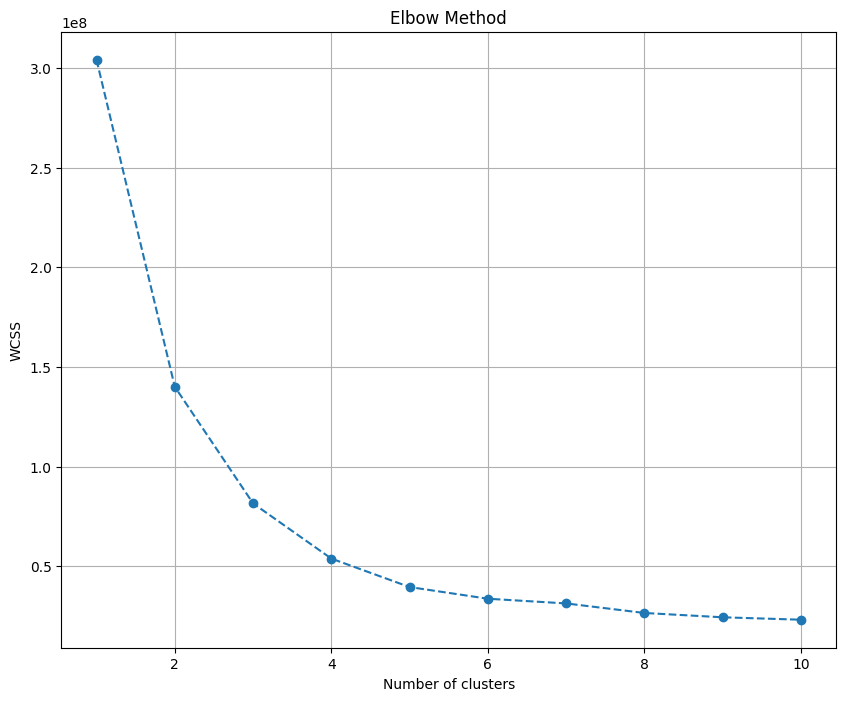

In [74]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_student_clicks)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss, marker = "o", linestyle = "--")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [121]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, verbose=2, random_state=42)
clusters = kmeans.fit_predict(df_student_clicks)

df_centroids = kmeans.cluster_centers_
df_distances = cdist(df_student_clicks, df_centroids, 'euclidean')

Initialization complete
Iteration 0, inertia 125228754.0.
Iteration 1, inertia 88381369.60073234.
Iteration 2, inertia 83438729.72432761.
Iteration 3, inertia 82264052.16219053.
Iteration 4, inertia 81754875.84027447.
Iteration 5, inertia 81536736.02341647.
Iteration 6, inertia 81497459.98701647.
Iteration 7, inertia 81495391.66392508.
Converged at iteration 7: strict convergence.


In [122]:
cluster_list = []

for c in clusters:
    cluster_list.append(c)
           
df_student_clicks["Cluster"] = cluster_list

In [123]:
df_student_clicks

,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks,Cluster
id_student,,,,,,,,,,,,
27935,3,142,0,259,2,64,38,41,231,33,813,1
28046,10,92,0,162,0,100,75,32,175,15,661,0
30549,2,7,0,58,2,32,0,3,33,0,137,0
31173,7,162,0,212,6,228,110,44,87,2,858,1
34653,3,36,0,39,0,45,5,18,64,3,213,0
39411,2,44,0,44,1,46,0,0,25,2,164,0
42818,4,72,0,43,2,40,0,2,30,7,200,0
50610,0,0,0,4,0,4,0,0,5,0,13,0
59275,0,177,0,99,0,143,23,23,56,1,522,0


In [124]:
silhouette_avg = silhouette_score(df_student_clicks, clusters)
print(f"Índice de Silueta promedio: {silhouette_avg}")

davies_bouldin = davies_bouldin_score(df_student_clicks, clusters)
print(f"Índice de Davies-Bouldin: {davies_bouldin}")

calinski_harabasz = calinski_harabasz_score(df_student_clicks, clusters)
print(f"Índice de Calinski-Harabasz: {calinski_harabasz}")

Índice de Silueta promedio: 0.583537865548839
Índice de Davies-Bouldin: 0.6505439074470085
Índice de Calinski-Harabasz: 919.8752138092817


In [125]:
df_cluster_students = df_dropout.copy()
df_cluster_students["Cluster"] = clusters

In [126]:
#Describe the clusters
cluster_analysis = df_cluster_students.groupby('Cluster').describe().T
pd.set_option('display.max_rows', None)

In [127]:
cluster_analysis.loc[df_student_clicks_features]

Cluster                                0            1            2
n_clicks_externalquiz  count  517.000000   145.000000    14.000000
                       mean     3.551257    10.462069    21.357143
                       std      4.793384    10.555423    12.506042
                       min      0.000000     0.000000     6.000000
                       25%      1.000000     4.000000    11.250000
                       50%      2.000000     7.000000    22.500000
                       75%      5.000000    13.000000    30.000000
                       max     38.000000    75.000000    46.000000
n_clicks_forumng       count  517.000000   145.000000    14.000000
                       mean    69.355899   295.062069  1127.000000
                       std     76.407548   177.678753   628.710891
                       min      0.000000     4.000000   355.000000
                       25%     10.000000   160.000000   709.750000
                       50%     43.000000   266.000000  1019.000000
                       75%    104.000000   405.000000  1179.250000
                       max    490.000000   794.000000  2618.000000
n_clicks_glossary      count  517.000000   145.000000    14.000000
                       mean     4.117988    10.358621    13.714286
                       std      9.137176    42.685490    18.894153
                       min      0.000000     0.000000     0.000000
                       25%      0.000000     0.000000     1.250000
                       50%      0.000000     0.000000     3.500000
                       75%      3.000000     5.000000    23.750000
                       max     63.000000   442.000000    62.000000
n_clicks_homepage      count  517.000000   145.000000    14.000000
                       mean    96.330754   304.958621   910.071429
                       std     64.132893   109.125811   352.624547
                       min      1.000000   131.000000   479.000000
                       25%     44.000000   222.000000   638.750000
                       50%     87.000000   278.000000   890.000000
                       75%    138.000000   361.000000  1021.500000
                       max    313.000000   696.000000  1631.000000
n_clicks_oucollaborate count  517.000000   145.000000    14.000000
                       mean     3.375242    14.765517    28.714286
                       std      6.539564    17.973365    20.105218
                       min      0.000000     0.000000     8.000000
                       25%      0.000000     3.000000    13.500000
                       50%      1.000000    10.000000    24.000000
                       75%      4.000000    19.000000    33.250000
                       max     48.000000    85.000000    78.000000
n_clicks_oucontent     count  517.000000   145.000000    14.000000
                       mean    84.410058   203.303448   239.785714
                       std     73.535799   134.719788   166.768923
                       min      0.000000    36.000000    80.000000
                       25%     32.000000   105.000000   124.250000
                       50%     59.000000   163.000000   199.500000
                       75%    116.000000   271.000000   274.000000
                       max    418.000000   903.000000   710.000000
n_clicks_ouwiki        count  517.000000   145.000000    14.000000
                       mean    11.833656    65.220690   126.428571
                       std     23.299353    61.061498   105.858188
                       min      0.000000     0.000000     0.000000
                       25%      0.000000     0.000000    18.750000
                       50%      0.000000    61.000000   119.000000
                       75%     12.000000   107.000000   205.750000
                       max    140.000000   318.000000   312.000000
n_clicks_resource      count  517.000000   145.000000    14.000000
                       mean    22.191489    73.586207   147.928571
                       std     18.716160    54.

In [128]:
pd.set_option('display.max_rows', False)

In [59]:
dict_clusters_all_students = {cluster: group.drop(columns=["Cluster"]) for cluster, group in df_cluster_students.groupby("Cluster")}

In [60]:
dict_clusters_selected_students = get_students(df_cluster_students, df_dropout, df_distances, df_centroids, "closest", 0.25)

Cluster 0: 130 students
Cluster 1: 37 students
Cluster 2: 4 students


In [ ]:
df_cluster_gcfe = pd.DataFrame(columns=X_train.columns.tolist())

for cluster in dict_clusters_all_students.keys():
    print(f"Cluster {cluster}")
    start_time = time.time()
    centroid_student, cluster_students, features, _, _, _, gcfe_values_coverage, gcfe = GCFE_features_clustering(dict_clusters_selected_students[cluster], positive_train_set, model, exp, features_to_vary, sample_size_percentage=1, n_features_percentage=0.3, global_features_importance=False)
    end_time = time.time()
    exec_time = end_time - start_time
    df_cluster_gcfe = pd.concat([df_cluster_gcfe, gcfe], ignore_index=True)

In [63]:
df_cluster_gcfe

,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,total_n_clicks
0,2,-,-,-,42,-,-,89,-,-,837
1,3,-,1,-,42,-,-,88,-,-,-
2,20,384,-,-,55,-,79,-,-,-,-


## Techniques evaluation

In [64]:
# Get the best combination for group counterfactual generation

def evaluate_group_cfe_generation_techniques(df_cluster_students, df_dropout, dict_clusters_all_students, distances, centroids, positive_train_set, X_train, model, explainer, features_to_vary, n_clusters, sample_size_percentage=0.5, n_features_percentage=0.3, n_loops=5, global_features_importance=False):
    # Define the different techniques and sample percentages to evaluate
    techniques = ['closest', 'farthest', 'random', 'full']
    percentages = [0.01, 0.05, 0.1, 0.25, 0.5]  # 1%, 5%, 10%, 25%, 50%
    
    # Initialize lists to store results and index values
    results = []
    index_list = []
    
    # Loop through each generation technique
    for technique in techniques:
        
        # Handle the 'full' technique where all students are used
        if technique == 'full':
            print(f"Technique: {technique}, Percentage: 100%")
            percentage = 1.0  # 100%
            # Get all students for the 'full' technique
            df_all_students = get_students(df_cluster_students, df_dropout, distances, centroids, "closest", percentage)
            start_time = time.time()
            # Calculate the success rate and execution time for all students
            success_rate, total_time = success_percentage(
                df_all_students, positive_train_set, dict_clusters_all_students, X_train, model, explainer, features_to_vary,
                n_clusters, sample_size_percentage, n_features_percentage, n_loops, global_features_importance
            )
            end_time = time.time()
            exec_time = (end_time - start_time) / n_loops
            total_exec_time = end_time - start_time
            index_list.append((technique, f"{percentage * 100}%"))
            results.append([success_rate, exec_time, total_exec_time])
        
        # Handle the remaining techniques with variable sampling percentages
        else:
            for percentage in percentages:
                print(f"Technique: {technique}, Percentage: {percentage}")
                # Select students based on the technique and percentage
                df_selected_students = get_students(df_cluster_students, df_dropout, distances, centroids, technique, percentage)
                start_time = time.time()
                # Calculate the success rate and execution time for selected students
                success_rate, total_time = success_percentage(
                    df_selected_students, positive_train_set, dict_clusters_all_students, X_train, model, explainer,
                    features_to_vary, n_clusters, sample_size_percentage, n_features_percentage, n_loops, global_features_importance
                )
                end_time = time.time()
                exec_time = (end_time - start_time) / n_loops
                total_exec_time = end_time - start_time
                index_list.append((technique, f"{percentage * 100}%"))  # Append technique and percentage to index
                results.append([success_rate, exec_time, total_exec_time])  # Append results for each technique and percentage
    
    # Create a DataFrame to store the results with multi-level index (Technique, Percentage students used)
    df_results = pd.DataFrame(results, columns=["Success rate", "Average time", "Total time"],
                      index=pd.MultiIndex.from_tuples(index_list, names=["Technique", "Percentage students used"]))
    
    # Return the results DataFrame
    return df_results

In [ ]:
results = evaluate_group_cfe_generation_techniques(df_cluster_students, df_dropout, dict_clusters_all_students, df_distances, df_centroids, positive_train_set, X_train, model, exp, features_to_vary, n_clusters, sample_size_percentage=1, n_features_percentage=0.3, n_loops=30, global_features_importance=False)

In [66]:
results

Success rate  Average time   Total time
Technique Percentage students used                                         
closest   1.0%                         92.194832      2.850006    85.500193
          5.0%                         94.555941     11.042406   331.272193
          10.0%                        93.821887     22.231011   666.930316
          25.0%                        98.146689     54.115240  1623.457191
          50.0%                        99.575260    107.424426  3222.732766
farthest  1.0%                         95.908547      2.595094    77.852821
          5.0%                         97.240574     11.869599   356.087955
          10.0%                        98.683062     22.669936   680.098079
          25.0%                        96.405583     53.637676  1609.130277
          50.0%                        98.246305     99.978989  2999.369680
random    1.0%                         96.135897      2.694008    80.820242
          5.0%                         96.740155     11.982363   359.470897
          10.0%                        98.749316     20.904906   627.147177
          25.0%                        96.374932     52.698249  1580.947464
          50.0%                        98.968254    101.199673  3035.990202
full      100.0%                      100.000000    217.428802  6522.864053

In [ ]:
success_percentage(dict_clusters_selected_students, positive_train_set, dict_clusters_all_students, X_train, model, exp, features_to_vary, n_clusters, sample_size_percentage=1, n_features_percentage=0.3, n_loops=30, global_features_importance=False)

## Evaluation

In [ ]:
dict_clusters_cfe = {}
dict_clusters_creation_times = {} 

for cluster_id, original_cluster in dict_clusters_all_students.items():
    modified_rows = []
    creation_times = [] 

    for i in range(original_cluster.shape[0]):
        start_time = time.time()  

        individual_cf = exp.generate_counterfactuals(original_cluster.iloc[[i]], total_CFs=1, desired_class=0, features_to_vary=features_to_vary, verbose=0)
        instance = original_cluster.iloc[i]
        cfe = individual_cf.cf_examples_list[0].final_cfs_df.squeeze()
        cfe = cfe.drop(labels="final_result")

        modified_row = {}
        
        for column in cfe.index:
            if cfe[column] != instance[column]:
                modified_row[column] = cfe[column] 
            else:
                modified_row[column] = '-'  
        
        modified_rows.append(modified_row)

        end_time = time.time() 
        creation_time = end_time - start_time 
        creation_times.append(creation_time)  

    individual_cfs_only_changes = pd.DataFrame(modified_rows)
    dict_clusters_cfe[cluster_id] = individual_cfs_only_changes
    dict_clusters_creation_times[cluster_id] = creation_times

### Evaluation functions

In [61]:
# Applies a counterfactual to a student by modifying only the columns where the counterfactual suggests a change.

def apply_counterfactual(row, counterfactual):
    new_row = row.copy()  
    for col in row.index:
        if counterfactual[col] != '-':
            new_row[col] = counterfactual[col]
    
    return new_row


# Evaluates the validity of individual counterfactuals for each student in the cluster.

def individual_validity(df_cluster_students, individual_cfs, model):
    individual_validities = []
    
    # Iterate over individual counterfactuals and corresponding students
    for i, (index, cf) in enumerate(individual_cfs.iterrows()):
        student = df_cluster_students.iloc[i].copy()  
        modified_student = apply_counterfactual(student, cf)
        
        modified_student = modified_student.to_frame().T
        
        # Predict whether the modified student is classified as valid (class 0)
        individual_validity = model.predict(modified_student)  
        individual_validity = 1 if individual_validity[0] == 0 else 0
        individual_validities.append(individual_validity)

    return individual_validities


# Evaluates the validity of a group counterfactual applied to all students in the cluster.

def group_validity(df_cluster_students, group_cf, model):
    # Applies the group counterfactual to each student in the cluster
    modified_cluster = df_cluster_students.apply(lambda row: apply_counterfactual(row, group_cf), axis=1)

    # Predict whether each modified student is classified as valid (class 0)
    group_validities = model.predict(modified_cluster)
    group_validities = np.array([1 if validity == 0 else 0 for validity in group_validities])
    
    return group_validities


# Compares the validity of individual and group counterfactuals for the given cluster of students.

def compare_validity(df_cluster_students, individual_cfs, group_cf, model):
    # Get validity scores for both group and individual counterfactuals
    group_validities = group_validity(df_cluster_students, group_cf, model)
    individual_validities = individual_validity(df_cluster_students, individual_cfs, model)
    
    # Calculate the average validity for both cases
    avg_individual_validity = sum(individual_validities) / len(individual_validities)
    avg_group_validity = sum(group_validities) / len(group_validities)

    print(f"Mean validity individual counterfactuals: {avg_individual_validity}")
    print(f"Mean validity group counterfactuals: {avg_group_validity}\n")

    return avg_individual_validity, avg_group_validity


In [62]:
# Calculates the sparsity of individual counterfactuals.

def individual_sparsity(individual_cfs):
    individual_sparsities = []

    # Iterates through each counterfactual
    for _, cf in individual_cfs.iterrows():
        # Calculates the ratio of unchanged features (features that are '-')
        individual_sparsity = sum(cf != '-') / cf.size
        individual_sparsity = 1 - individual_sparsity  # Sparsity is higher when fewer features change
        individual_sparsities.append(individual_sparsity)
        
    return individual_sparsities


# Calculates the sparsity of a group counterfactual when applied to individual students.

def group_sparsity(df_cluster_students, group_cf):
    group_sparsities = []

    # Iterates through each student in the cluster
    for _, student in df_cluster_students.iterrows():
        instance_group_sparsity = 0

        # Compares each feature in the student's data with the group counterfactual
        for col in group_cf.index:
            if group_cf[col] != '-':  # Only count features that have been changed in the counterfactual
                if student[col] != group_cf[col]:
                    instance_group_sparsity += 1  # Increments when the student’s feature differs from the counterfactual
        
        # Calculates the sparsity for the current student
        group_sparsity = instance_group_sparsity / group_cf.size
        group_sparsity = 1 - group_sparsity  # Higher sparsity means fewer changes
        group_sparsities.append(group_sparsity)
    
    return group_sparsities


# Compares the average sparsity of individual and group counterfactuals.

def compare_sparsity(df_cluster_students, individual_cfs, group_cf):
    # Retrieves individual and group sparsity scores
    individual_sparsities = individual_sparsity(individual_cfs)
    group_sparsities = group_sparsity(df_cluster_students, group_cf)

    # Computes the average sparsity for both individual and group counterfactuals
    avg_individual_sparsity = sum(individual_sparsities) / len(individual_sparsities)
    avg_group_sparsity = sum(group_sparsities) / len(group_sparsities)
    
    # Prints out the mean sparsity for comparison
    print(f"Mean sparsity individual counterfactuals: {avg_individual_sparsity}")
    print(f"Mean sparsity group counterfactuals: {avg_group_sparsity}\n")
    
    return avg_individual_sparsity, avg_group_sparsity


In [63]:
# Calculates the Median Absolute Deviation (MAD) for specified numeric columns in the DataFrame of students who dropped out.

def calculate_mad(df_dropout, numeric_columns):
    return df_dropout[numeric_columns].apply(lambda x: (x - x.median()).abs().median())


# Calculates numeric proximity between the original student data and the counterfactual.

def calculate_numeric_proximity(original, cf, mad_values):
    n_num_columns = len(original)
    valid = (cf != '-') & (mad_values != 0)
    
    if np.sum(valid) == 0:
        return np.nan  # Return NaN if no valid features exist
    
    sum_continuous_distance = 0
    for i in range(n_num_columns):
        if valid[i]:
            continuous_distance = np.sum(np.abs(cf.iloc[i] - original.iloc[i]) / mad_values[i])
            sum_continuous_distance += continuous_distance
    
    continuous_distance = sum_continuous_distance / n_num_columns  # Average distance calculation

    proximity = -continuous_distance  # Proximity is negative of distance

    return proximity  


# Calculates categorical proximity by comparing original data with the counterfactual.

def calculate_categorical_proximity(original, cf):
    n_cat_columns = len(original)
    valid = cf != '-'

    if np.sum(valid) == 0:
        return 1  # Return proximity of 1 if all features are unchanged

    categorical_distance = 0
    for i in range(n_cat_columns):
        if valid[i]:
            if cf.iloc[i] != original.iloc[i]:
                categorical_distance += 1  # Count how many features differ

    categorical_distance /= n_cat_columns  # Normalize by number of features 

    proximity = 1 - categorical_distance  # Proximity is inverse of distance

    return proximity


# Calculates numeric and categorical proximity for individual counterfactuals against the original data in the cluster.

def individual_proximity(df_cluster_students, individual_cfs, numeric_columns, categorical_columns):
    # Calculate the MAD for numeric columns
    mad_values = calculate_mad(df_cluster_students, numeric_columns)
    
    individual_proximity_numeric = []
    individual_proximity_categorical = []
    
    # Iterate over original students and their corresponding individual counterfactuals
    for (_, orig), (_, ind_cf) in zip(df_cluster_students.iterrows(), individual_cfs.iterrows()):
        orig_numeric = orig[numeric_columns]
        ind_numeric = ind_cf[numeric_columns]
       
        orig_categorical = orig[categorical_columns]
        ind_categorical = ind_cf[categorical_columns]

        # Calculate proximity for numeric and categorical data
        cont_proximity = calculate_numeric_proximity(orig_numeric, ind_numeric, mad_values)
        cat_proximity = calculate_categorical_proximity(orig_categorical, ind_categorical)

        individual_proximity_numeric.append(cont_proximity)
        individual_proximity_categorical.append(cat_proximity)
    
    return (individual_proximity_numeric, individual_proximity_categorical)


# Calculates numeric and categorical proximity for the group counterfactual against each student in the cluster.

def group_proximity(df_cluster_students, group_cf, numeric_columns, categorical_columns):
    mad_values = calculate_mad(df_cluster_students, numeric_columns)
    
    group_proximity_numeric = []
    group_proximity_categorical = []
    
    # Iterate over each original student to calculate proximity to the group counterfactual
    for _, orig in df_cluster_students.iterrows():
        orig_numeric = orig[numeric_columns]
        group_numeric = group_cf[numeric_columns]

        orig_categorical = orig[categorical_columns]
        group_categorical = group_cf[categorical_columns]

        cont_proximity = calculate_numeric_proximity(orig_numeric, group_numeric, mad_values)
        cat_proximity = calculate_categorical_proximity(orig_categorical, group_categorical)
        
        group_proximity_numeric.append(cont_proximity)
        group_proximity_categorical.append(cat_proximity)

    return (group_proximity_numeric, group_proximity_categorical)


# Compares the average numeric and categorical proximity for individual and group counterfactuals.

def compare_proximity(df_cluster_students, individual_cfs, group_cf, numeric_columns, categorical_columns):
    individual_proximity_numeric, individual_proximity_categorical = individual_proximity(df_cluster_students, individual_cfs, numeric_columns, categorical_columns) 
    
    # Calculate the average proximity for individual counterfactuals
    avg_individual_proximity_numeric = np.nanmean(individual_proximity_numeric)
    avg_individual_proximity_categorical = np.nanmean(individual_proximity_categorical)

    print(f"Mean numeric proximity individual counterfactuals: {avg_individual_proximity_numeric}")
    print(f"Mean categoric proximity individual counterfactuals: {avg_individual_proximity_categorical}\n")
    
    # Calculate the proximity for the group counterfactuals
    group_proximity_numeric, group_proximity_categorical = group_proximity(df_cluster_students, group_cf, numeric_columns, categorical_columns)
    
    avg_group_proximity_numeric = np.nanmean(group_proximity_numeric)
    avg_group_proximity_categorical = np.nanmean(group_proximity_categorical)

    print(f"Mean numeric proximity group counterfactuals: {avg_group_proximity_numeric}")
    print(f"Mean categoric proximity group counterfactuals: {avg_group_proximity_categorical}")

    return (avg_individual_proximity_numeric, avg_individual_proximity_categorical), (avg_group_proximity_numeric, avg_group_proximity_categorical)


In [65]:
# Evaluate the clusters 

def evaluate_all_clusters(dict_clusters_all_students, dict_clusters_selected_students, features_to_vary, X_train, model, exp, positive_train_set, categorical_columns, numeric_columns, n_loops=5):
    all_results = []  # List to store the results of all clusters
    index_list = []  # List to store the MultiIndex tuples for the result DataFrame
    n_students = [len(dict_clusters_all_students[cluster]) for cluster in dict_clusters_all_students.keys()]  # Number of students in each cluster

    df_cluster_gcfe = pd.DataFrame(columns=X_train.columns.tolist())  # DataFrame to store group counterfactuals for each cluster

    for cluster_id, cluster_students in dict_clusters_all_students.items():  # Iterate over each cluster
        cluster_results = []  # Store results for the current cluster over all iterations
        time_individuals = []  # Store times for individual counterfactual generation
        
        for i in range(n_loops):  # Repeat evaluation multiple times for robustness
            print(f"\n--- Evaluating Cluster {cluster_id} iteration {i}---")
            results = []  # Store individual and group results for this iteration
            modified_rows = []  # Store only the modified features for each individual counterfactual
            start_individual_time = time.time()

            for j in range(cluster_students.shape[0]):  # Process each student in the cluster
                #start_individual_time = time.time()  # Track time to generate individual counterfactual

                # Generate individual counterfactual
                try:
                    individual_cf = exp.generate_counterfactuals(cluster_students.iloc[[j]], total_CFs=1, desired_class=0, features_to_vary=features_to_vary, verbose=0)
                
                except Exception as e:
                    end_individual_time = time.time()
                    break 
                
                instance = cluster_students.iloc[j]
                
                cfe = individual_cf.cf_examples_list[0].final_cfs_df.squeeze()  # Extract the generated counterfactual
                cfe = cfe.drop(labels="final_result")  # Drop the 'Target' column
                
                modified_row = {}  # Track which features were changed
                
                # For each feature, check if the value has changed in the counterfactual
                for column in cfe.index:
                    if cfe[column] != instance[column]:
                        modified_row[column] = cfe[column]  # Store the new value if changed
                    else:
                        modified_row[column] = '-'  # Use '-' to indicate no change
                
                modified_rows.append(modified_row)  # Add the modified row for this individual

                """ end_individual_time = time.time()  # Track the end time
                time_individual = end_individual_time - start_individual_time  # Calculate the time taken
                time_individuals.append(time_individual)  # Store the time taken for this individual """

            end_individual_time = time.time()  # Track the end time
            individual_time = end_individual_time - start_individual_time  # Calculate the time taken
            
            
            # Create DataFrame with only the changed features from individual counterfactuals
            individual_cfs_only_changes = pd.DataFrame(modified_rows)
            mean_time_individual = np.mean(time_individuals)  # Calculate average time for individual counterfactuals
            
            # Generate group counterfactual and measure time
            start_time_group = time.time()
            _, _, _, _, _, _, _, gcfe = GCFE_features_clustering(
                dict_clusters_selected_students[cluster_id], positive_train_set, model, exp, features_to_vary, sample_size_percentage=1, n_features_percentage=0.3, global_features_importance=False
            )

            df_cluster_gcfe = pd.concat([df_cluster_gcfe, gcfe], ignore_index=True)  # Store the generated group counterfactual
            end_time_group = time.time()
            group_time = end_time_group - start_time_group  # Calculate total group time

            #group_time_individual = group_time / cluster_students.shape[0]  # Average group time per student
            group_cf = gcfe.squeeze()  # Extract group counterfactual
            
            # Calculate validity for individual and group counterfactuals
            avg_individual_validity, avg_group_validity = compare_validity(cluster_students, individual_cfs_only_changes, group_cf, model)
            
            # Calculate sparsity for individual and group counterfactuals
            total_individual_sparsity, total_group_sparsity = compare_sparsity(cluster_students, individual_cfs_only_changes, group_cf)
            
            # Calculate proximity (numeric and categorical) for individual and group counterfactuals
            (avg_individual_proximity_numeric, avg_individual_proximity_categorical), (avg_group_proximity_numeric, avg_group_proximity_categorical) = compare_proximity(
                cluster_students, individual_cfs_only_changes, group_cf, numeric_columns, categorical_columns)
            
            # Append individual and group results for this iteration
            results.append([avg_individual_validity, total_individual_sparsity, avg_individual_proximity_numeric, avg_individual_proximity_categorical, individual_time])
            results.append([avg_group_validity, total_group_sparsity, avg_group_proximity_numeric, avg_group_proximity_categorical, group_time])
            cluster_results.append(results)
            
        # Average results over all iterations for this cluster
        averaged_results = np.nanmean(cluster_results, axis=0)
        
        # Append individual and group results to the final results list
        index_list.append((f"{cluster_id}", f"{n_students[cluster_id]}", "Individual"))
        all_results.append(averaged_results[0])
        
        index_list.append((f"{cluster_id}", f"{n_students[cluster_id]}", "Group"))
        all_results.append(averaged_results[1])
    
    # Create DataFrame to hold all results with MultiIndex for cluster, number of students, and type
    df_results = pd.DataFrame(
        all_results, 
        columns=["Validity", "Sparsity", "Proximity Numeric", "Proximity Categorical", "Time per cluster"],
        index=pd.MultiIndex.from_tuples(index_list, names=["Cluster", "Cluster Students", "Counterfactual Type"])
    )

    return df_results


In [ ]:
cluster_results = evaluate_all_clusters(dict_clusters_all_students, dict_clusters_selected_students, features_to_vary, X_train, model, exp, positive_train_set, categorical_features, numerical_features, n_loops=30)

In [67]:
cluster_results

Validity  Sparsity  \
Cluster Cluster Students Counterfactual Type                       
0       517              Individual           1.000000  0.835778   
                         Group                1.000000  0.649552   
1       145              Individual           1.000000  0.849133   
                         Group                0.994943  0.645747   
2       14               Individual           1.000000  0.845238   
                         Group                0.919048  0.636580   

                                              Proximity Numeric  \
Cluster Cluster Students Counterfactual Type                      
0       517              Individual                  -16.244996   
                         Group                        -4.441531   
1       145              Individual                   -5.870673   
                         Group                        -1.029124   
2       14               Individual                   -6.193216   
                         Group                        -0.773567   

                                              Proximity Categorical  \
Cluster Cluster Students Counterfactual Type                          
0       517              Individual                             1.0   
                         Group                                  1.0   
1       145              Individual                             1.0   
                         Group                                  1.0   
2       14               Individual                             1.0   
                         Group                                  1.0   

                                              Time per cluster  
Cluster Cluster Students Counterfactual Type                    
0       517              Individual                 135.464418  
                         Group                       35.570728  
1       145              Individual                  37.942187  
                         Group                       13.488339  
2       14               Individual                   3.586913  
                         Group                        1.131954

## Comparison visualization of counterfactuals plot

### Group counterfactuals plot

In [135]:
# Apply the counterfactuals to students
dict_clusters_gcfe_applied = copy.deepcopy(dict_clusters_all_students)

for i in range(3):
    for column in df_cluster_gcfe.columns:
        if df_cluster_gcfe.iloc[i][column] != '-':
            dict_clusters_gcfe_applied[i][column] = df_cluster_gcfe.iloc[i][column]

In [137]:
def model_pred(x):
    scores = exp.predict_fn(pd.concat([df_structure, pd.DataFrame(x, columns=feature_names)], ignore_index=True))
    return scores
    
feature_names = exp.data_interface.feature_names
df_structure = exp.data_interface.data_df[:0].loc[:, feature_names]
out_exp = []

for i in range(3):
    for j in range(3):
        out_exp.append(CreatePlot(
            factual=np.array(dict_clusters_all_students[i].iloc[j]),
            cf=np.array(dict_clusters_gcfe_applied[i].iloc[j]),
            model_pred=model_pred,
            feature_names=feature_names,
            class_names={0: 'No Dropout', 1: 'Dropout'}))

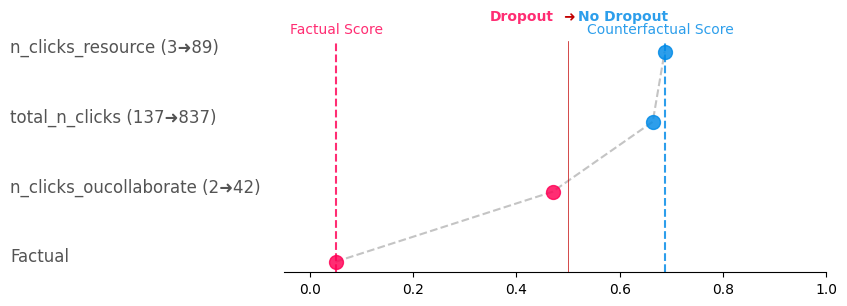

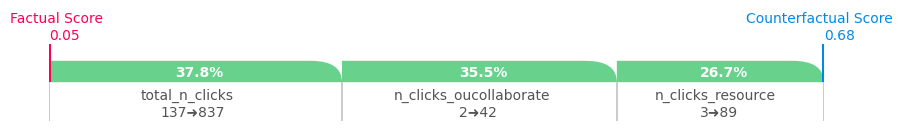

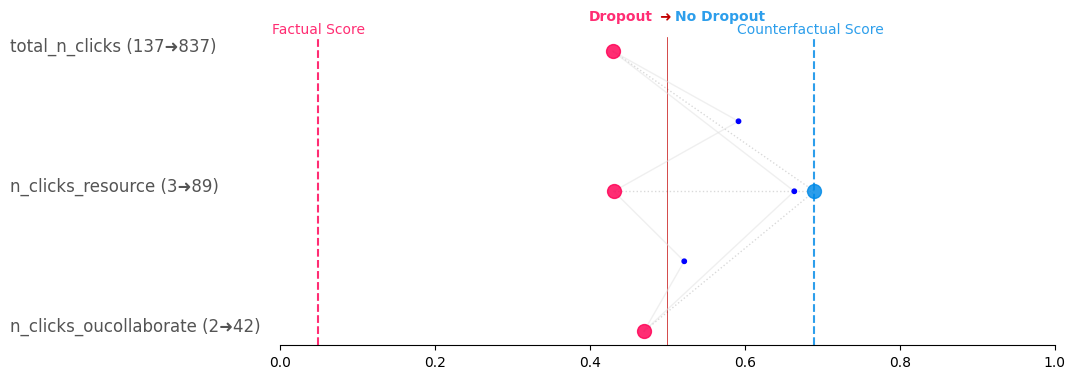

In [138]:
out_exp[1].greedy()
out_exp[1].countershapley()
out_exp[1].constellation()

### Individual counterfactuals plot

In [139]:
# Same student used as the group counterfactual plot
counterfactual_plot_instance = exp.generate_counterfactuals(dict_clusters_all_students[0].iloc[[9]], total_CFs=1, desired_class=0, features_to_vary=features_to_vary)
counterfactual_plot_instance = counterfactual_plot_instance.cf_examples_list[0].final_cfs_df
counterfactual_plot_instance.drop(columns=["final_result"], axis=1, inplace=True)

100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


In [140]:
def model_pred(x):
    scores = exp.predict_fn(pd.concat([df_structure, pd.DataFrame(x, columns=feature_names)], ignore_index=True))
    return scores
    
feature_names = exp.data_interface.feature_names
df_structure = exp.data_interface.data_df[:0].loc[:, feature_names]
out_exp = []

out_exp.append(CreatePlot(
    factual=np.array(dict_clusters_all_students[0].iloc[9]),
    cf=np.array(counterfactual_plot_instance.squeeze()),
    model_pred=model_pred,
    feature_names=feature_names,
    class_names={0: 'No Dropout', 1: 'Dropout'}))

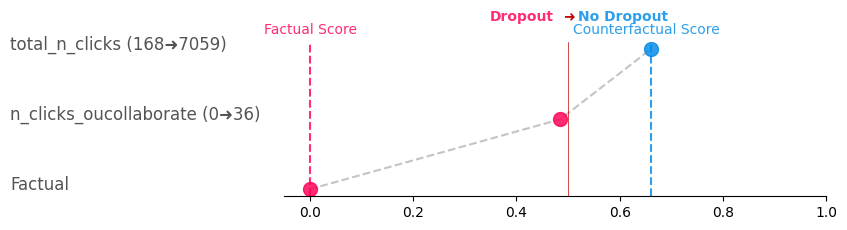

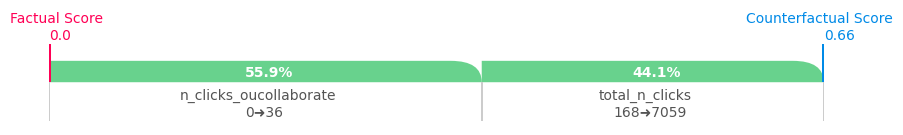

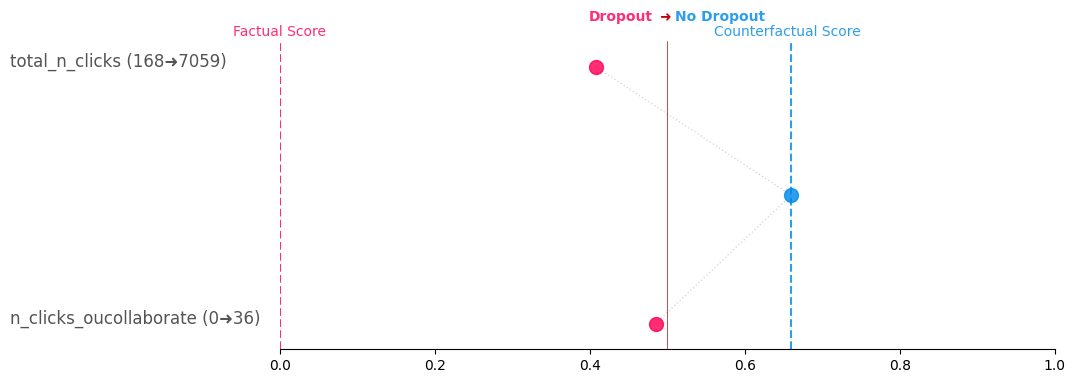

In [141]:
out_exp[0].greedy()
out_exp[0].countershapley()
out_exp[0].constellation()